In [15]:
#scientific libraries and plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

#torch specific
import torch

#other libraries
import sys
from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import atlas_mpl_style as ampl

In [16]:
# import custom functions from src folder
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from machine_learning import *
from resnet import *
from imcal import *

from resnet import ResNet18

# Predict using resnet

This notebook uses a saved resnet model to predict on test data and generate a confusion matrix. It also saves the wrong predictions for further analysis.

In [17]:
#variables controlled by the user. Change these to fit your specific needs.
RES = 50 #resolution

#LABELS = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "BH_n4_M8", "BH_n2_M10", "BH_n4_M10", "BH_n6_M10", "BH_n4_M12"]
LABELS = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "BH_n2_M10", "BH_n4_M8", "BH_n4_M10", "BH_n4_M12", "BH_n6_M10"]
TEST_LABELS = [f"{label}_test" for label in LABELS]
PLOT_LABELS = ["SPH_9", "BH_n4_M8", "BH_n2_M10", "BH_n4_M10", "BH_n6_M10", "BH_n4_M12"]
#PLOT_LABELS = ["SPH_9", "BH_n2_M10", "BH_n4_M8", "BH_n4_M10", "BH_n4_M12", "BH_n6_M10"]
PLOT_ORDER = [0, 2, 1, 3, 5, 4]
CLASSES = len(LABELS) #The number of output nodes in the net, equal to the number of classes
FOLDERS = ["sph", "BH", "BH", "BH", "BH", "BH"]
TEST_N_EVENTS = 15000
CUT=True

#Set data paths
if CUT:
    N_EVENTS = 15000
    TEST_FILENAMES = [f"{label}_res{RES}_STmin7_Nmin5_{N_EVENTS}_events.h5" for label in TEST_LABELS]
else:
    N_EVENTS = 3000
    TEST_FILENAMES = [f"{label}_res{RES}_{N_EVENTS}_events.h5" for label in TEST_LABELS]
TEST_DATAPATHS = [f"/disk/atlas3/data_MC/2dhistograms/{FOLDERS[i]}/{RES}/{TEST_FILENAMES[i]}" for i in range(CLASSES)]

MODEL_NAME = "resnet18_1703078471_SPH_9_BH_n2_M10_BH_n4_M8_BH_n4_M10_BH_n4_M12_BH_n6_M10_CUT"
LOAD_FOLDER = "../results/models/experiment_resnet18_1703074946_SPH_9_BH_n2_M10_BH_n4_M8_BH_n4_M10_BH_n4_M12_BH_n6_M10_CUT"
LOAD_PATH = f"{LOAD_FOLDER}/{MODEL_NAME}.pt"

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    torch.cuda.empty_cache()
    print("Running on the GPU")
else:
    DEVICE = torch.device("cpu")
    print("Running on the CPU")
DEVICE = torch.device("cpu")
ampl.use_atlas_style() 

Running on the GPU


In [18]:
#import model
model = ResNet18(img_channels=3, num_classes=len(TEST_LABELS))
model.load_state_dict(torch.load(LOAD_PATH))
model.eval()
model.to(DEVICE)
print("Loading model")

Loading model


In [27]:
#Load data
testpaths = [Path(path) for path in TEST_DATAPATHS]
test_data = load_datasets(testpaths, DEVICE, TEST_N_EVENTS, filters=[None], transforms=None)
test_data = Hdf5Dataset(testpaths, TEST_LABELS, DEVICE, 
                        shuffle=False, filters=[None], transform=None, event_limit=TEST_N_EVENTS)
eventids = test_data.getids().flatten()
if len(eventids) != len(test_data):
    print("Error in lengths of arrays")


Loads data with transforms None and filters [None]
Loaded data with 15000 entries of shape (15000, 50, 50, 3).
Check max value: 25613.0859375.
Loaded data with 15000 entries of shape (15000, 50, 50, 3).
Check max value: 40609.1484375.
Loaded data with 15000 entries of shape (15000, 50, 50, 3).
Check max value: 19851.11328125.
Loaded data with 15000 entries of shape (15000, 50, 50, 3).
Check max value: 23127.8984375.
Loaded data with 15000 entries of shape (15000, 50, 50, 3).
Check max value: 35996.286259531975.
Loaded data with 15000 entries of shape (15000, 50, 50, 3).
Check max value: 30371.03125.
Data has shape torch.Size([50, 50, 3])
There are 6 classes.
Opening file /disk/atlas3/data_MC/2dhistograms/sph/50/PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_test_res50_STmin7_Nmin5_15000_events.h5.
Selecting 15000 events out of 15000.
Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n2_M10_test_res50_STmin7_Nmin5_15000_events.h5.
Selecting 15000 events out of 15000.
Opening file /disk/at

In [28]:
truth, preds, confidences = predict(model, test_data, CLASSES, 100, RES, DEVICE, return_values=True)

100%|██████████| 900/900 [01:28<00:00, 10.17it/s]


In [29]:
df = pd.DataFrame(dict(zip(["Truth", "Prediction"], [truth, preds])))
df["EventID"] = eventids
accuracy = accuracy_score(truth, preds, normalize=True)
df['Confidence'] = torch.max(confidences, dim=-1)[0]

[91.2   1.91  6.31  0.15  0.18  0.25 11.98 56.69 12.58  5.26 12.37  1.12
  5.99  2.79 49.33 11.15 22.18  8.56  3.23  3.47 35.09 13.36 35.85  8.99
  2.66  3.91 28.88 13.6  42.07  8.87  0.59  0.31  3.19  1.13  2.35 92.43]
Accuracy: 0.5751444444444445


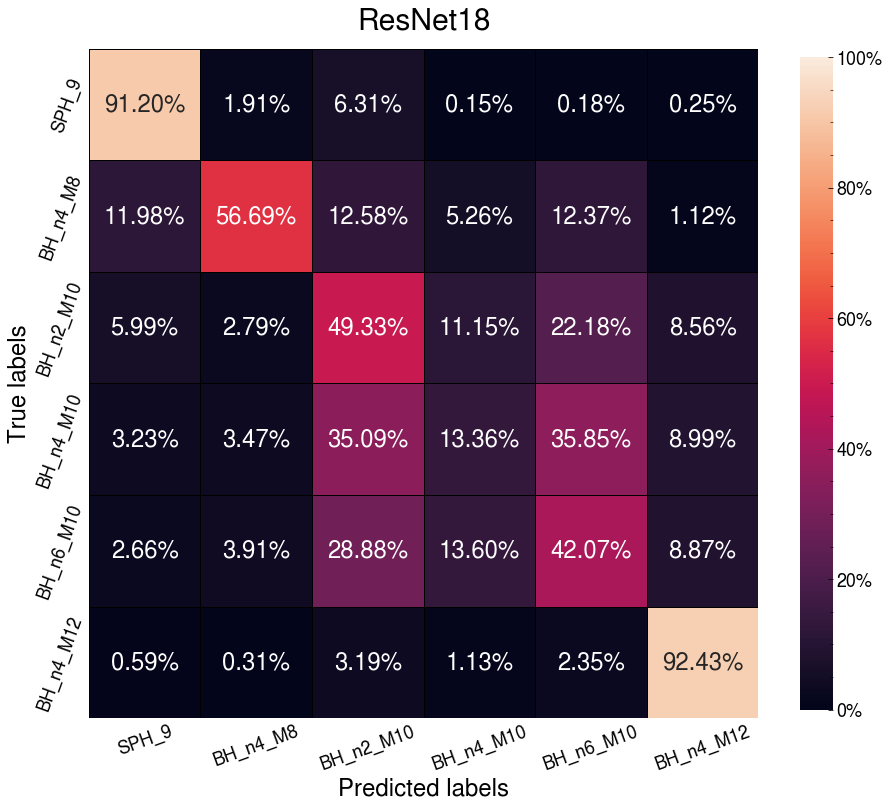

In [30]:
def plot_conf_matrix(confusion, accuracy, labels):
    """
    plot confusion matrix
    """
    fig, ax = plt.subplots(1,1, figsize=(15, 15))

    #Generate the confusion matrix
    cf_matrix = confusion_matrix(confusion["Truth"], confusion["Prediction"], normalize="true")
    cf_matrix = 100*np.round(cf_matrix, 4)
    cf_matrix = np.array([cf_matrix[i] for i in PLOT_ORDER])
    cf_matrix = np.array([np.array([row[j] for j in PLOT_ORDER]) for row in cf_matrix])
    print(cf_matrix.flatten())
    group_counts = ["{0:0.0f}".format(value*TEST_N_EVENTS) for value in cf_matrix.flatten()]
    group_percentages = ["{0:0.2%}".format(value/100) for value in cf_matrix.flatten()]
    annot = [f"{item}" for item in group_percentages]
    annot = np.asarray(annot).reshape(len(labels),len(labels))
    sn.heatmap(
            cf_matrix, 
            ax=ax, 
            annot=annot, 
            cmap='rocket', 
            linewidths=1.0, 
            linecolor='black',
            cbar = True, 
            square=True, 
            fmt='', 
            cbar_kws={"format": "%.0f%%", "shrink": 0.8},
            vmin=0,
            vmax=100,
            annot_kws={"size": 24}
        )

    #ax.set_title('Confusion matrix\n\n', size=24)
    ax.set_xlabel('Predicted labels', size=24)
    ax.set_ylabel('True labels', size=24)

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(labels, size=18, rotation=20)
    ax.yaxis.set_ticklabels(labels, size=18, rotation=70)
    ax.tick_params(which="both", left=False, bottom=False, top=False, right=False)
    ax.set_title(f"ResNet18", size=30, pad=20)
    print(f"Accuracy: {accuracy}")

    ## Display the visualization of the Confusion Matrix.
    fig.savefig(f"../results/figures/ResNet18_{TEST_N_EVENTS}_events_CUT_conf_matrix.pdf", format="pdf", bbox_inches='tight')
    plt.show()
plot_conf_matrix(df, accuracy, PLOT_LABELS)

In [31]:
df_wrong = df[df["Prediction"] != df["Truth"]]

In [32]:
#Look at the confidences
for i in range(len(LABELS)):
    temp = df[df["Truth"]==i]
    temp_len = len(temp)
    print(f"Predictions on truth {temp_len} {LABELS[i]} events:")
    for j in range(len(LABELS)):
        temp_preds = temp[temp["Prediction"]==j]
        print(f"{len(temp_preds)} events predicted as {LABELS[j]}")
        print(f"Average confidence: {temp_preds['Confidence'].mean()}, Std: {temp_preds['Confidence'].std()}")
    print("----")

Predictions on truth 15000 PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL events:
13680 events predicted as PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL
Average confidence: 0.8685343861579895, Std: 0.16206608712673187
946 events predicted as BH_n2_M10
Average confidence: 0.4008524417877197, Std: 0.0849657878279686
286 events predicted as BH_n4_M8
Average confidence: 0.5114011168479919, Std: 0.17471690475940704
23 events predicted as BH_n4_M10
Average confidence: 0.30260610580444336, Std: 0.055180542171001434
38 events predicted as BH_n4_M12
Average confidence: 0.4415420591831207, Std: 0.15675708651542664
27 events predicted as BH_n6_M10
Average confidence: 0.3118036389350891, Std: 0.04072704538702965
----
Predictions on truth 15000 BH_n2_M10 events:
898 events predicted as PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL
Average confidence: 0.6586859822273254, Std: 0.20461735129356384
7400 events predicted as BH_n2_M10
Average confidence: 0.42075127363204956, Std: 0.07458891719579697
419 events predicted as B

[0.00000000e+00 4.44444444e-05 2.62333333e-02 1.30566667e-01
 6.40222222e-02 3.16888889e-02 3.28666667e-02 4.99444444e-02
 2.39777778e-01]


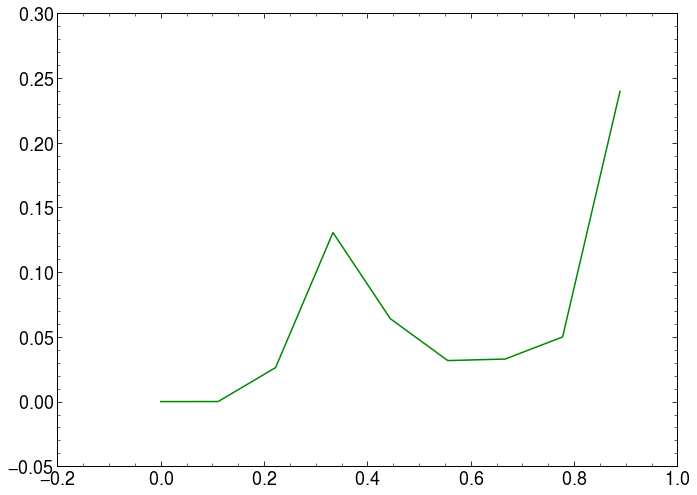

In [33]:
#Reliability diagram
##NOT DONE##
conf_bins = np.linspace(0, 1, 10)
N_conf, bins = np.histogram(df['Confidence'].values, conf_bins)
N_conf_wrong = np.histogram(df_wrong['Confidence'].values, conf_bins)[0]
N_conf_right = N_conf - N_conf_wrong
n_conf_right = N_conf_right/len(df)
print(n_conf_right)
plt.plot(conf_bins[0:-1], n_conf_right)

In [34]:
def save_wrong_predictions(truths, labels, eventids, savepath, filename):
    file = open(f"{savepath}/{filename}.csv", "w")
    file.write(f"Wrongly predicted events from datasets: {testpaths} by model {MODEL_NAME}")
    for i, truth in enumerate(truths):
        file.write(f"{labels[int(truth)]}, {eventids[i]}\n")
    file.close()
    print(f"Saved results to {savepath}/{filename}.csv")
    
filename = f"{MODEL_NAME}_{TEST_N_EVENTS}_events_wrongly_predicted"
save_wrong_predictions(df_wrong["Truth"].tolist(), PLOT_LABELS, df_wrong["EventID"].tolist(), "../results/", filename)

Saved results to ../results//resnet18_1703078471_SPH_9_BH_n2_M10_BH_n4_M8_BH_n4_M10_BH_n4_M12_BH_n6_M10_CUT_15000_events_wrongly_predicted.csv
